<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_diffusion_prep_STEAM_2D_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt
!pip install ismrmrd

import numpy as np
import torch
import matplotlib.pyplot as plt
import pypulseq as pp
import MRzeroCore as mr0

(diff_prep_STEAM_seq)=

# Diffusion prepared STEAM
We use a $T_2$ preparation module consisting of $90°$, $180°$, $-90°$ pulses and diffusion gradients.
To spoil away the FID, which might have a different random phase than the stored diffusion-prepped magnetization, we add extra spoilers after the $180°$ pulse and during the prewinder phase.

## Diffusion b-value calculation
Diffusion reduces the magnetization by a factor of $e^{-bD}$, where $b$ is the sequence-specific b-value and $D$ the tissue-specific apperent diffusion coefficient.
For a diffusion gradient - refocusing RF pulse - diffusion gradient preparation like used here, the b-value can be calculated like follows:

$ b = (\gamma G)^2 \delta^2 \cdot (\Delta − \delta/3) $

where
- $\gamma$ is the Larmor frequency of water: $42.58 \, MHz / T$ or $267.5 \times 10^6 \, rad / T$
- $G$ is the gradient amplitude in $T / m$
- $\delta$ is the duration of the diffusion gradients
- $\Delta$ is the time from the start of the first gradient to the start of the second

Typical values for the apparent diffusion coefficient are:
| tissue       | ADC $[10^{-3} \, mm^2 / s]$ |
| ------------ | ---------------------- |
|  gray matter |                   0.83 |
| white matter |                   0.65 |
|          CSF |                   3.19 |

In [2]:
experiment_id = 'mr0_diffusion_prepped_STEAM_2D'

# Still plays out the preparation block but without diffusion gradients
disable_diff_prep = False  # @param {type: "boolean"}
# How far to spoil FID and magnetization after readout (in multiples of k-space)
spoil_factor = 1.5  # @param {type: "slider", min:0, max:3, step:0.1}
# Centric (True) or linear (False) reordering
reorder_centric = True  # @param {type: "boolean"}
# Duration (in ms) of the diffusion preparation gradient at maximum amplitude
diff_grad_dur = 30e-3  # @param {type: "slider", min:1e-3, max:100e-3, step:0.1e-3}

fov = 200e-3
slice_thickness = 8e-3
Nread = 64
Nphase = 64
adc_dwell = 30e-6
rf_phase_cycling = 84 * np.pi / 180

# Scanner limits
system = pp.Opts(max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
                 rf_ringdown_time=20e-6, rf_dead_time=100e-6, adc_dead_time=20e-6,
                 grad_raster_time=50*10e-6)

In [3]:
#@title b-value calculation

# b = (γG)² δ² (Δ−δ/3) = ω² δ² (Δ−δ/3)
# [s/m^2] = [2π/s]^2 * [s]^2 * [s]
# Pulseq stores gradient amplitudes as frequencies (ω not G), so there is no γ in b-value calculation

delta = diff_grad_dur
Delta = delta + 1e-3 + system.rf_dead_time + system.rf_ringdown_time
b_value = (2 * np.pi * system.max_grad)**2 * delta**2 * (Delta - delta / 3)

print("gamma")
print(f"> {system.gamma * 1e-6:8.2f} MHz/m")
print("gradient amplitude")
print(f"> {system.max_grad * 1e-3:8.2f} kHz/m")
print(f"> {system.max_grad / system.gamma * 1e3:8.2f} mT/m")
print("b-value")
print(f"> {b_value*1e-6:8.2f} s/mm^2")

gamma
>    42.58 MHz/m
gradient amplitude
>  1192.13 kHz/m
>    28.00 mT/m
b-value
>  1066.45 s/mm^2


In [4]:
#@title Build the sequence

# preparation pulses, 1st excitation is slice selective
rf90, rf90_gz, rf90_gzr = pp.make_sinc_pulse(
    flip_angle= 90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
rf180 = pp.make_block_pulse(flip_angle=180 * np.pi / 180, phase_offset=90 * np.pi / 180, duration=1e-3, system=system)
rf90_store = pp.make_block_pulse(flip_angle=90 * np.pi / 180, phase_offset=180 * np.pi / 180,duration=1e-3, system=system)
# readout pulse
rf = pp.make_block_pulse(flip_angle=5 * np.pi / 180, duration=1e-3, system=system)

# preparation gradient for diffusion weighting
diff_grad = pp.make_trapezoid(channel='y', amplitude=system.max_grad, duration=diff_grad_dur, system=system)
# readout gradient
gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=Nread * adc_dwell, system=system)
# move prepared mag away from k-space center for separation from FID
gx_store = pp.make_trapezoid(channel='x', area=-(gx.area / 2 + gx.area * spoil_factor), system=system)
# move STE (prepared mag) to start of k-space readout
gx_pre = pp.make_trapezoid(channel='x', area=gx.area * spoil_factor, duration=1.5e-3, system=system)
# spoil after each k-space line
gx_spoil = pp.make_trapezoid(channel='x', area=spoil_factor * gx.area, duration=1.5e-3, system=system)
# spoil transversal magnetization after preparation
gz_spoil = pp.make_trapezoid(channel='z', area=spoil_factor * gx.area, duration=1.5e-3, system=system)

adc = pp.make_adc(num_samples=Nread, dwell=adc_dwell, delay=gx.rise_time, system=system)


if disable_diff_prep:
    diff_grad = pp.make_delay(pp.calc_duration(diff_grad))

if reorder_centric:
    phenc = [i // 2 if i % 2 == 0 else -(i + 1) // 2 for i in range(Nphase)]
else:
    phenc = [i - Nphase // 2 for i in range(Nphase)]


seq = pp.Sequence()
# STE preparation
seq.add_block(rf90, rf90_gz)
seq.add_block(diff_grad, rf90_gzr)
seq.add_block(rf180)
seq.add_block(diff_grad, gx_store)
seq.add_block(rf90_store)
seq.add_block(gz_spoil)

# FLASH readout
for jj in range(0, Nphase):
    rf.phase_offset = rf_phase_cycling * 0.5 * (jj**2 + jj + 2)
    adc.phase_offset = rf.phase_offset

    seq.add_block(rf)
    gp = pp.make_trapezoid(channel='y', area=phenc[jj]/fov, duration=1e-3, system=system)
    seq.add_block(gx_pre, gp)
    n_lin = Nread // 2 + phenc[jj]
    seq.add_block(adc, gx, pp.make_label(label="LIN", type="SET", value=n_lin))
    gp = pp.make_trapezoid(channel='y', area=-phenc[jj]/fov, duration=1e-3, system=system)
    seq.add_block(gx_spoil, gp)

# write .seq file
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition("RES", [Nread, Nphase, 1])
seq.set_definition('Name', 'gre')
seq.write(experiment_id + '.seq')

ok, errors = seq.check_timing()
if not ok:
    for error in errors:
        print(error, end="")

/var/folders/rr/w7cs6t1x0dl8cc5_ng28z6lr0000gp/T/ipykernel_95608/1994842997.py:4: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf90, rf90_gz, rf90_gzr = pp.make_sinc_pulse(
/var/folders/rr/w7cs6t1x0dl8cc5_ng28z6lr0000gp/T/ipykernel_95608/1994842997.py:9: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf180 = pp.make_block_pulse(flip_angle=180 * np.pi / 180, phase_offset=90 * np.pi / 180, duration=1e-3, system=system)
/var/folders/rr/w7cs6t1x0dl8cc5_ng28z6lr0000gp/T/ipykernel_95608/1994842997.py:10: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf90_store = pp.make_block_pulse(flip_angle=90 * np.pi / 180, phase_offset=180 * np.pi / 180,duration=1e-3, system=system)
/var/folders/rr/w7cs6t1x0dl8cc5_ng28z6lr0000gp/T/ipykernel_95608/1994842997.py:12: UserWarning: Specified RF delay 0.00 

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


/opt/homebrew/Caskroom/miniforge/base/envs/mri_p312/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


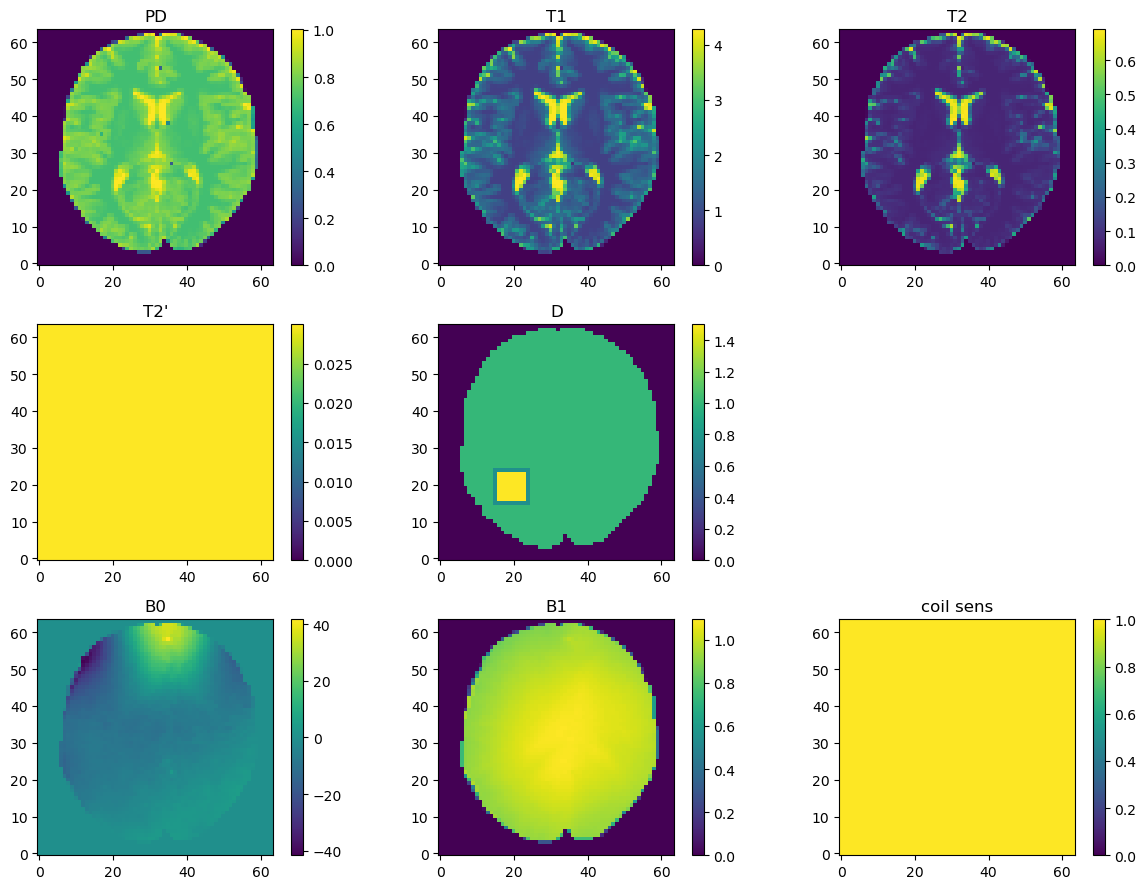

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.000574625 s
Compute Graph
Computing Graph: 0.011347084 s
Analyze Graph
Analyzing Graph: 0.00023125 s
Converting Rust -> Python: 0.007669209 s
<<<< Rust <<<<


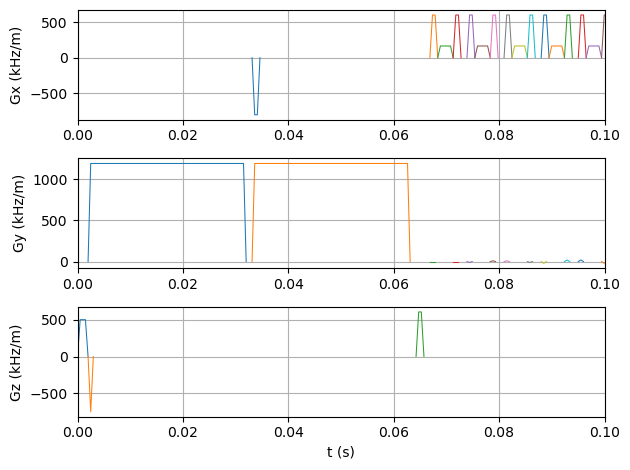

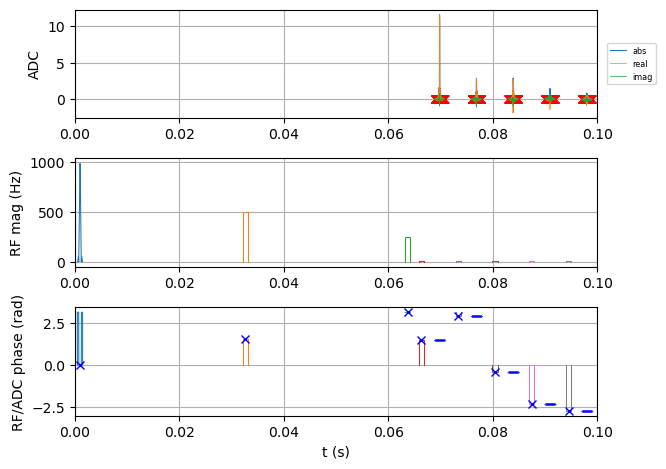

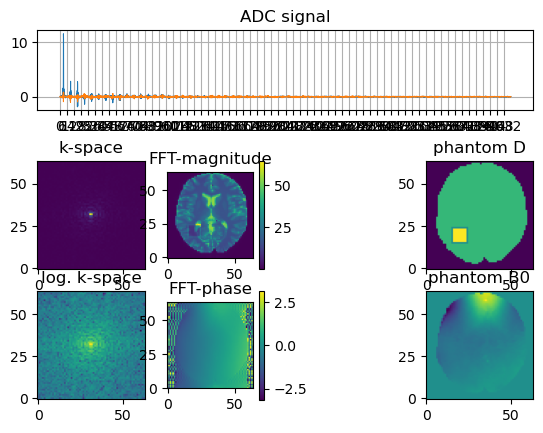

In [5]:
# @title simulate

obj_p = mr0.util.load_phantom(size=(64, 64))

# (ii) insert rectangular "Tumor"
# typical brain tumor ADC values are around ~1.5 * 10^-3 mm^2/s,
# which lies between GM/WM and CSF (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3000221)
# mr0 uses D in units of [10^-3 * mm^2/s] = [µm^2/ms]
obj_p.D[:] = 0
obj_p.D[obj_p.PD > 0] = 1
# construct tumor border region
for ii in range(15, 25):
    for jj in range(15, 25):
        obj_p.D[ii, jj] = 0.75
# construct tumor filling
for ii in range(16, 24):
    for jj in range(16, 24):
        obj_p.D[ii, jj] = torch.tensor(1.5)

# Store PD and B0 for comparison
D = obj_p.D
B0 = obj_p.B0
obj_p.plot()

# Simulate
obj_p = obj_p.build()
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
graph = mr0.compute_graph(seq0, obj_p, 2000, 1e-4)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

# PLOT sequence with signal in the ADC subplot
seq.plot(plot_now=False, time_range=(0, 0.1))
mr0.util.insert_signal_plot(seq, signal.numpy())
plt.show()

# %% S6: MR IMAGE RECON of signal ::: #####################################
ipermvec = np.argsort(phenc)
kspace = signal.reshape(Nphase, Nread)[ipermvec, :].T
space = torch.fft.ifftshift(torch.fft.fft2(torch.fft.fftshift(kspace)))

plt.figure()
plt.subplot(411)
plt.title('ADC signal')
plt.plot(torch.real(signal), label='real')
plt.plot(torch.imag(signal), label='imag')
plt.xticks(np.arange(Nphase) * Nread)
plt.grid()

plt.subplot(345)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(349)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(346)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(3, 4, 10)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# % compare with original phantom obj_p.PD
plt.subplot(348)
plt.title('phantom D')
mr0.util.imshow(D)
plt.subplot(3, 4, 12)
plt.title('phantom B0')
mr0.util.imshow(B0)
plt.show()

simulated prep b-value: 1039.136474609375 s / mm^2


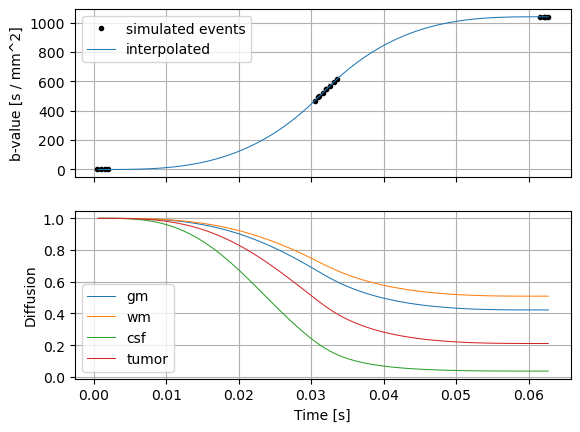

In [6]:
# @title b-value plot for simulated sequence

# Calculate the b-value from the MR0 sequence, identical to the main_pass.
# There is a refocussing pulse in the middle so we just flip the second grad
gradm = np.concatenate([seq0[0].gradm[:, 1], -seq0[1].gradm[:, 1]])
dt = np.concatenate([seq0[0].event_time, seq0[1].event_time])

k2 = np.cumsum(gradm)
# k2 is end of event, for integration we also need start of event (k1):
k1 = np.zeros_like(k2)
k1[1:] = k2[:-1]

# Integration over linear interpolation of k-space trajectory
b = 1/3 * (2 * np.pi)**2 * dt * (k1**2 + k1*k2 + k2**2)  # s/m^2

# Interpolate the trajectory for a finer plot
dt_i = np.full((100, ), dt.sum() / 100)
k2_i = np.interp(np.cumsum(dt_i), np.cumsum(dt), k2)
k1_i = np.zeros_like(k2_i)
k1_i[1:] = k2_i[:-1]
b_i = 1/3 * (2 * np.pi)**2 * dt_i * (k1_i**2 + k1_i*k2_i + k2_i**2)

# Includes gradient ramps - might differ slightly from b-value above
print(f"simulated prep b-value: {np.sum(b) * 1e-6} s / mm^2")

diffusion_gm = np.exp(-1e-9 * 0.83 * np.cumsum(b_i))
diffusion_wm = np.exp(-1e-9 * 0.65 * np.cumsum(b_i))
diffusion_csf = np.exp(-1e-9 * 3.19 * np.cumsum(b_i))
diffusion_tumor = np.exp(-1e-9 * 1.5 * np.cumsum(b_i))

plt.figure()
ax1 = plt.subplot(211)
plt.plot(np.cumsum(dt), np.cumsum(b) * 1e-6, "k.", label="simulated events")
plt.plot(np.cumsum(dt_i), np.cumsum(b_i) * 1e-6, label="interpolated")
plt.ylabel("b-value [s / mm^2]")
plt.grid()
plt.legend()
plt.tick_params("x", labelbottom=False)

plt.subplot(212, sharex=ax1)
plt.plot(np.cumsum(dt_i), diffusion_gm, label="gm")
plt.plot(np.cumsum(dt_i), diffusion_wm, label="wm")
plt.plot(np.cumsum(dt_i), diffusion_csf, label="csf")
plt.plot(np.cumsum(dt_i), diffusion_tumor, label="tumor")
plt.grid()
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Diffusion")
plt.show()

In [7]:
# @title Save Signal to ISMRMRD file
import ismrmrd

mr0.sig_to_mrd("mr_zero.mrd", signal, seq, verbose=1)

Create ISMRMRD dataset at 'mr_zero.mrd'


Write readouts to mrd file: 100%|██████████| 64/64 [00:00<00:00, 1927.06acq/s]


In [8]:
# @title Read ISMRMRD file
dset = ismrmrd.Dataset("mr_zero.mrd", "dataset", create_if_needed=False)

mrd_header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())

mrd_data_shape = (
    mrd_header.encoding[0].encodedSpace.matrixSize.x,
    mrd_header.encoding[0].encodedSpace.matrixSize.y,
    mrd_header.acquisitionSystemInformation.receiverChannels,
)
mrd_data = np.zeros(mrd_data_shape, dtype=np.complex64)

num_acq = dset.number_of_acquisitions()
for n_acq in range(num_acq):
    acq = dset.read_acquisition(n_acq)
    acq_head = acq.getHead()
    n_lin = acq_head.idx.kspace_encode_step_1

    mrd_data[:, n_lin, :] = acq.data.T

print("Loaded data with shape (Nread, Nphase, Nchannel):", mrd_data.shape)

Loaded data with shape (Nread, Nphase, Nchannel): (64, 64, 1)


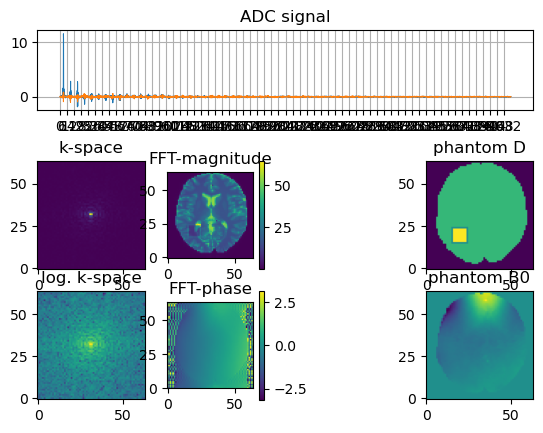

In [9]:
# @title Reconstruct image from ISMRMRD data
kspace = torch.from_numpy(mrd_data)
kspace = kspace[..., 0]  # 1 channel

space = torch.fft.ifftshift(torch.fft.fft2(torch.fft.fftshift(kspace)))

plt.figure()
plt.subplot(411)
plt.title("ADC signal")
plt.plot(torch.real(signal), label="real")
plt.plot(torch.imag(signal), label="imag")
plt.xticks(np.arange(Nphase) * Nread)
plt.grid()

plt.subplot(345)
plt.title("k-space")
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(349)
plt.title("log. k-space")
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(346)
plt.title("FFT-magnitude")
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(3, 4, 10)
plt.title("FFT-phase")
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# % compare with original phantom obj_p.PD
plt.subplot(348)
plt.title("phantom D")
mr0.util.imshow(D)
plt.subplot(3, 4, 12)
plt.title("phantom B0")
mr0.util.imshow(B0)
plt.show()